In [85]:
# %load exploratory_behavior_2hand.py


#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 13 11:53:01 2018

@author: stiso
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# read data
top_dir = '/Users/stiso/Documents/Python/graphLearning/ECoG data/'
subj = '6'
HUPID = '196'
data_raw = pd.read_csv("".join((top_dir, 'behavioral_data_raw/HUP', HUPID, '_typingtask/subj', subj, '_log_motor_run1.csv')))
# load all sessions

ext = ['2']
for sess in ext:
    curr_sess = pd.read_csv("".join((top_dir, 'behavioral_data_raw/HUP', HUPID, '_typingtask/subj', subj, '_log_motor_run', sess, '.csv')))
    data_raw = pd.concat([data_raw, curr_sess])
    
save_dir = "".join((top_dir, 'behavioral_data_raw/subj', subj, '/'))
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
data = data_raw
data["graph"][1]

1    modular
1    modular
Name: graph, dtype: object

In [86]:
# add block
data['block'] = data['trialNum']
for index, row in data.iterrows():
    if row['trialNum'] < 251:
        data.loc[index,'block'] = 1
    elif row['trialNum'] > 250 and row['trialNum'] < 501:
        data.loc[index,'block'] = 2
    elif row['trialNum'] > 500 and row['trialNum'] < 751:
        data.loc[index,'block'] = 3
    elif row['trialNum'] > 750:
        data.loc[index,'block'] = 4
           
data.tail()

,sess,graph,trialNum,resp,path,pID,walk,ISI_raw,correct_raw,onset_raw,resp_raw,rt_raw,typing_raw,order,block
998,2,modular,999.0,q,img/target_1.png,6.0,0.0,0.05,1.0,959.738525,['q'],0.616166,c,998.0,4.0
999,2,modular,1000.0,u,img/target_7.png,6.0,3.0,0.05,1.0,960.438538,['u'],0.731852,c,999.0,4.0
1000,extraInfo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,START,1.78813934326e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,END,961.250294924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
data.describe()

,trialNum,pID,walk,ISI_raw,correct_raw,onset_raw,rt_raw,order,block
count,2000.000000,2000.0,2000.000000,2000.00,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,500.500000,6.0,4.343000,0.05,0.966000,489.717661,0.812034,499.500000,2.500000
std,288.747186,0.0,2.919523,0.00,0.181274,290.805090,0.355537,288.747186,1.118314
min,1.000000,6.0,0.000000,0.05,0.000000,0.009734,0.377442,0.000000,1.000000
25%,250.750000,6.0,2.000000,0.05,1.000000,231.362392,0.639145,249.750000,1.750000
50%,500.500000,6.0,4.000000,0.05,1.000000,495.541550,0.730395,499.500000,2.500000
75%,750.250000,6.0,7.000000,0.05,1.000000,745.629669,0.856807,749.250000,3.250000
max,1000.000000,6.0,9.000000,0.05,1.000000,988.798218,5.751362,999.000000,4.000000


In [88]:
# Basic preprocessing

data.dropna(inplace=True)

# get cutoff threshold - 2 std's above
cutoff = 2.*data["rt_raw"].std() + data["rt_raw"].mean()
print(cutoff)

accuracy = (sum(data["correct_raw"] == 1)*100)/data["correct_raw"].count()
print(accuracy)


1.52310914636
96


In [89]:
import scipy.io as sio

# save variables that you need for ECoG data - correct, outside of cutoff, walk, trial
walk = data['walk'].values
trial = data['order'].values + 1
cutoff = (data['rt_raw'] > 0.050).values & (data['rt_raw'] < cutoff).values
correct = data['correct_raw'].values

sio.savemat("".join([top_dir, 'ephys_raw/', subj, '/task_data.mat']), {'walk':walk, 'trial':trial, 'cutoff':cutoff, 'correct':correct})
cutoff


array([ True,  True,  True, ...,  True,  True,  True])

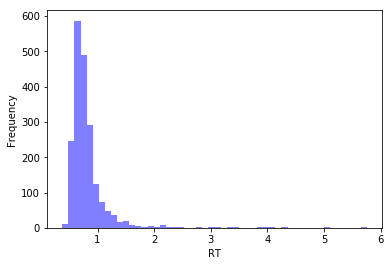

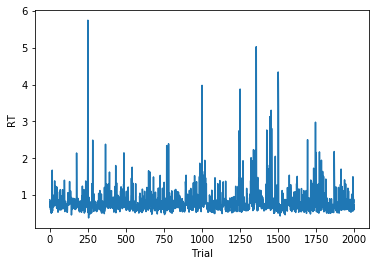

In [90]:
# plot
num_bins = 50
fig = plt.figure()
# the histogram of the data
plot_data = data.rt_raw.tolist()
n, bins, patches = plt.hist(plot_data, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('RT')
plt.ylabel('Frequency')
fig.savefig("".join([save_dir, 'subj', subj, '_rt_hist.png']))

fig = plt.figure()
plt.plot(plot_data)
plt.xlabel('Trial')
plt.ylabel('RT')
fig.savefig("".join([save_dir, 'subj', subj, '_rt.png']))

#%% Get transition data

transitions = [0,9,4,5]
#transitions = [1,2,7,8]
trans_idx = [False]
tmp = data.walk.tolist()
for i,n in enumerate(data.walk.tolist()):
    if i > 0:
        if n in transitions and tmp[i-1] in transitions:
            trans_idx.append(True)
        else:
            trans_idx.append(False)
    
    


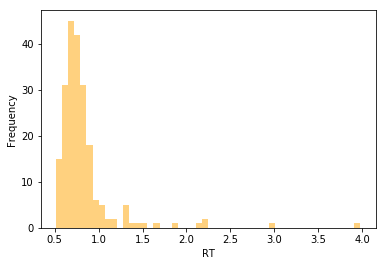

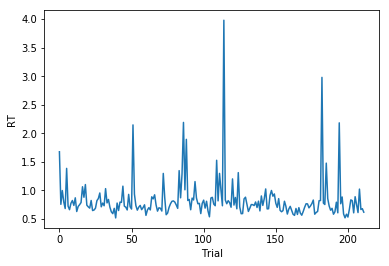

In [91]:
transition_data = data.loc[trans_idx]

# append transition to data
data['transition'] = trans_idx
data['transition'] = data['transition'].astype('category')

# plot
num_bins = 50
fig = plt.figure()
# the histogram of the data
plot_data = transition_data.rt_raw.tolist()
n, bins, patches = plt.hist(plot_data, num_bins, facecolor='orange', alpha=0.5)
plt.xlabel('RT')
plt.ylabel('Frequency')
fig.savefig("".join([save_dir, 'subj', subj, '_rt_hist_trans.png']))

fig = plt.figure()
plt.plot(plot_data)
plt.xlabel('Trial')
plt.ylabel('RT')
fig.savefig("".join([save_dir, 'subj', subj, '_rt_trans.png']))




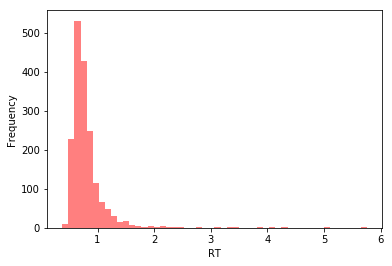

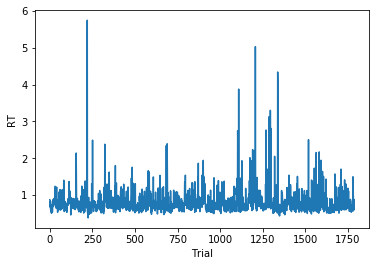

In [92]:
#%% Not transition data   
within_data = data[data["transition"] == 0]

# plot
num_bins = 50
fig = plt.figure()
# the histogram of the data
plot_data = within_data.rt_raw.tolist()
n, bins, patches = plt.hist(plot_data, num_bins, facecolor='red', alpha=0.5)
plt.xlabel('RT')
plt.ylabel('Frequency')
fig.savefig("".join([save_dir, 'subj', subj, '_rt_hist_within.png']))

fig = plt.figure()
plt.plot(plot_data)
plt.xlabel('Trial')
plt.ylabel('RT')
fig.savefig("".join([save_dir, 'subj', subj, '_rt_within.png']))




In [93]:
#%% Summary stats

print(transition_data.rt_raw.mean())
print(within_data.rt_raw.mean())
print(data.rt_raw.mean())



0.827675402164
0.810179826664
0.812034357667


In [94]:
# make predictors for recency and priming, according to karuza paper
# lag10
lag = 10
walk = data.walk.astype(float)
walk = walk.tolist()
# append zeros to the beginning
for i in range(lag):
   walk.insert(0,np.nan)
lag10 = [];
for i,n in enumerate(walk):
    if i > 9:
        curr = walk[(i-10):(i-1)]
        lag10.append(curr.count(n))
    
# recency
walk = data.walk.astype(float)
walk = walk.tolist()
recency = [np.nan]
for i,n in enumerate(walk):
    if i > 0:
        curr = walk[0:(i-1)]
        if n in curr:
            idx = i - max(loc for loc, val in enumerate(curr) if val == n)
        else:
            idx = np.nan
        recency.append(idx)
        


# hand transition index
left = ['q', 'w', 'e', 'r', 'v']
right = ['b', 'u', 'i', 'o', 'p']
hand = []
hand_transition = [False]
for i,key in enumerate(data.resp):
    if key in left:
        hand.append('left')
    elif key in right:
        hand.append('right')
    else:
        hand.append(np.nan)
        
    if i > 0:
        if len(hand) == 0:
            hand_transition.append(False)
        elif hand[i] != hand[i-1]:
            hand_transition.append(True)
        else:
            hand_transition.append(False)
            




In [95]:
#%%
            
import statsmodels.api as sm

data['lag10'] = lag10
data['order'] = (data['order'] + 1) # not taking log
data['recency'] = recency
data['resp'] = data['resp'].astype('category')
data['hand'] = hand
data['hand_transition'] = hand_transition
data['hand'] = data['hand'].astype('category')
data['hand_transition'] = data['hand_transition'].astype('category')

# accuracy
print(np.mean(data.correct_raw[data.transition == 1]))
print(np.mean(data.correct_raw[data.transition == 0]))

# cut down to only relevant fields
# get only correct responses, that are within 2 std
data = data[data.correct_raw == 1 & cutoff]
data = data.dropna(how='any')

# convert to float
data.rt_raw = data.rt_raw.apply(float)


model_data = data.dropna(how='any')
#model_data = model_data[model_data.trialNum >600] # if you want to look after they have learned
Y = model_data["rt_raw"]
X = model_data[["transition", "lag10", "recency", "order", "resp", "hand_transition", "block", 'sess']]
X = sm.add_constant(X)
X["resp"].cat.categories = [1,2,3,4,5,6,7,8,9,10]
#X["hand"].cat.categories = [1,2]



0.971698113208
0.965324384787


In [99]:
model_data.to_csv("".join([save_dir, 'subj', subj, '_clean_data']))

# Note the difference in argument order
model = sm.OLS(Y, X.astype(float)).fit()
predictions = model.predict(X) # make the predictions by the model


#%% Print out the statistics
model.summary()


TypeError: can't multiply sequence by non-int of type 'float'

In [98]:
#%% Check for colinearity

#from libraries.settings import *
from scipy.stats.stats import pearsonr
import itertools

correlations = {}
columns = X.columns.tolist()

for col_a, col_b in itertools.combinations(columns, 2):
    correlations[col_a + '__' + col_b] = pearsonr(X.loc[:, col_a], X.loc[:, col_b])

result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC', 'p-value'] 

print(result)


/Users/stiso/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [12]:
transitions = [0,9,4,5]
#transitions = [1,2,7,8]
trans_idx = [0]
tmp = data.walk.tolist()
for i,n in enumerate(data.walk.tolist()):
    if i > 0:
        if n in transitions and tmp[i-1] in transitions:
            trans_idx.append(1)
        else:
            trans_idx.append(0)

data['transition'] = trans_idx
print(data["transition"])
data.to_csv("".join([save_dir, 'subj', subj, '_trans.csv']))


0       0
1       0
2       0
3       0
4       1
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      1
24      0
25      0
26      0
27      0
28      0
29      0
       ..
973     0
974     0
975     0
976     0
977     0
978     0
979     0
980     1
981     1
982     0
983     0
984     0
985     0
986     0
987     0
988     1
989     0
990     0
991     0
992     0
993     0
994     0
995     0
996     0
997     0
998     0
999     0
1000    0
1001    0
1002    0
Name: transition, Length: 1003, dtype: int64
